In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # For progress bar, optional but helpful
import tensorflow as tf


2024-07-19 10:26:09.246244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 10:26:09.246383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 10:26:09.428729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
def load_data(root_dir):
    X_train = []
    Y_train = []
    
    label_dirs = sorted(os.listdir(os.path.join(root_dir, 'test', 'test')))
    for label in label_dirs:
        label_path = os.path.join(root_dir, 'test', 'test', label)
        if os.path.isdir(label_path):
            for img_name in tqdm(os.listdir(label_path)):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                X_train.append(img)
                Y_train.append(int(label))  # Assuming labels are integers
        
    return np.array(X_train), np.array(Y_train)


In [3]:
root_dir = '/kaggle/input/hand-gesture-recognition-dataset'
X_train, Y_train = load_data(root_dir)


100%|██████████| 900/900 [00:02<00:00, 361.89it/s]


In [4]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")


X_train shape: (18000, 50, 50, 3)
Y_train shape: (18000,)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(X_train, Y_train, num_images=5):
    """
    Display random images from X_train along with their corresponding labels from Y_train.
    
    Parameters:
    - X_train: numpy array, shape (num_samples, height, width, channels)
               Array containing images as numpy arrays.
    - Y_train: numpy array, shape (num_samples,)
               Array containing corresponding labels for each image in X_train.
    - num_images: int, optional (default=5)
                  Number of random images to display.
    """
    # Generate random indices
    random_indices = np.random.randint(0, len(X_train), num_images)
    
    # Plotting the random images
    plt.figure(figsize=(15, 7))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X_train[idx])
        plt.title(f'Label: {Y_train[idx]}')
        plt.axis('off')

    plt.show()

# Example usage:
# Assuming X_train and Y_train are already defined and loaded from your dataset
# X_train and Y_train should be in the correct format (numpy arrays of images and labels)


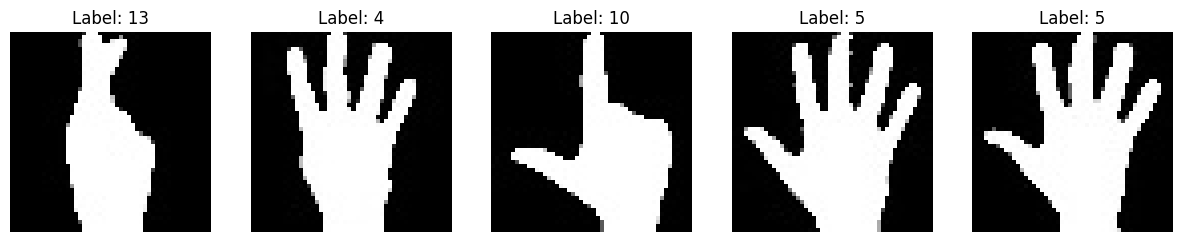

In [6]:
display_random_images(X_train, Y_train, num_images=5)


In [7]:
resnet = tf.keras.applications.ResNet152(
        include_top = False,
        weights = 'imagenet',
        input_shape = ((50, 50, 3))
)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
resnet.layers[-10:]

[<Conv2D name=conv5_block3_1_conv, built=True>,
 <BatchNormalization name=conv5_block3_1_bn, built=True>,
 <Activation name=conv5_block3_1_relu, built=True>,
 <Conv2D name=conv5_block3_2_conv, built=True>,
 <BatchNormalization name=conv5_block3_2_bn, built=True>,
 <Activation name=conv5_block3_2_relu, built=True>,
 <Conv2D name=conv5_block3_3_conv, built=True>,
 <BatchNormalization name=conv5_block3_3_bn, built=True>,
 <Add name=conv5_block3_add, built=True>,
 <Activation name=conv5_block3_out, built=True>]

In [15]:
for layer in resnet.layers[-10:]:
    layer.Trainable = True

In [16]:
from tensorflow.keras.layers import Dense, Flatten

f = Flatten()(resnet.layers[-1].output)
out = Dense(20, activation = 'softmax')(f)

In [17]:
from tensorflow.keras import Model

model = Model(inputs = resnet.inputs, outputs = out)

In [18]:
from tensorflow.keras.optimizers import Adam

opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

In [19]:
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train)

In [22]:
model.fit(X_train, Y_train, epochs = 1, batch_size = 32)

563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9939 - loss: 0.0520


In [32]:
root_dir = '/kaggle/input/hand-gesture-recognition-dataset'
X_test, Y_test = load_data(root_dir)

100%|██████████| 300/300 [00:00<00:00, 1008.69it/s]


In [35]:
Y_test = to_categorical(Y_test)

In [36]:
# Y_test = Y_test.reshape((-1, 20))

print(Y_test.shape)
print(X_test.shape)

(6000, 20)
(6000, 50, 50, 3)


In [37]:
model.evaluate(X_test, Y_test)

  4/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9720 - loss: 0.6422 

W0000 00:00:1721385635.516546     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9853 - loss: 0.2141


W0000 00:00:1721385645.913248     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.16916759312152863, 0.984000027179718]

In [38]:
predictions = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step


In [39]:
print(predictions[0:5])

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  7.2728511e-40 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.8528463e-15 1.1322623e-38 5.9989587e-41 0.0000000e+00
  1.2859790e-26 4.8464813e-26 2.5269111e-31 0.0000000e+00 8.3

In [40]:
# Convert predictions to integer labels
predicted_labels = np.argmax(predictions, axis=1)


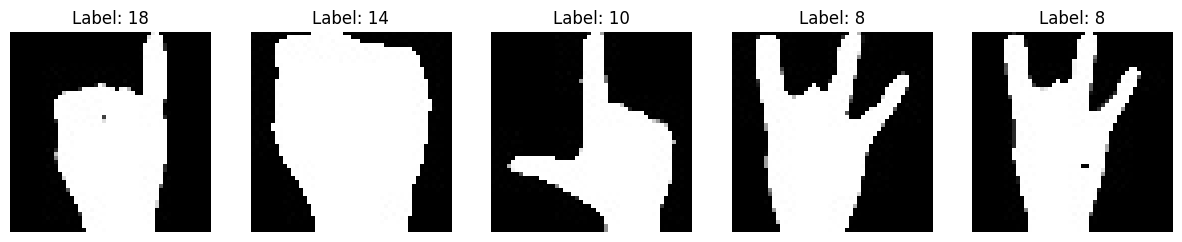

In [47]:
display_random_images(X_test, predicted_labels)